In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [85]:
train_limpio = pd.read_csv("train_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)
test_limpio = pd.read_csv("test_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)

In [86]:
train_limpio["text"] = train_limpio["text"].map(lambda x : "null" if(x is None) else x)
test_limpio["text"] = test_limpio["text"].map(lambda x : "null" if(x is None) else x)

In [87]:
train_limpio_true = train_limpio.loc[train_limpio["target"] == 1]
train_limpio_false = train_limpio.loc[train_limpio["target"] == 0]

In [88]:
print("Tenemos {cant_verdaderos: .2f} verdaderos y {cant_falsos: .2f} falsos".format(cant_verdaderos=len(train_limpio_true), cant_falsos=len(train_limpio_false)))

Tenemos  3271.00 verdaderos y  4342.00 falsos


## Voy a balancear el train y el validation, misma cantidad de falsos y verdaderos en ambos

In [89]:
train = pd.concat([train_limpio_true.iloc[:2616], train_limpio_false.iloc[:3473]])
val = pd.concat([train_limpio_true.iloc[2616:3000], train_limpio_false.iloc[3473:3850]])
test = pd.concat([train_limpio_true.iloc[3000:], train_limpio_false.iloc[3850:]])

In [90]:
train.head(2)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,wound-keyword,wreck-keyword,wreckag-keyword,isRealPlace,longitud_tweet,letras_seguidas,sentimiento,objetividad,keyword,location
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,110,2,0.5,0.5,outbreak,LAGOS
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,110,2,0.0,0.0,fatal,NaN


In [91]:
vectorizer = CountVectorizer()
vectorizer.fit(train_limpio["text"].values.astype('U'))

X_train = vectorizer.transform(train["text"].values.astype('U'))
X_val  = vectorizer.transform(val["text"].values.astype('U'))
X_test = vectorizer.transform(test["text"].values.astype('U'))

actual_tp_test_only_text = vectorizer.transform(test_limpio["text"].values.astype('U'))

In [92]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Primer modelo simple

In [93]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 10)                133800    
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 11        
Total params: 133,811
Trainable params: 133,811
Non-trainable params: 0
_________________________________________________________________


In [94]:
first_history = model.fit(X_train, train["target"].to_numpy(),
                    epochs=100,
                    verbose=True,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

Epoch 1/100
609/609 [==============================] - 1s 1ms/step - loss: 0.5423 - acc: 0.7561 - val_loss: 0.4759 - val_acc: 0.8081
Epoch 2/100
609/609 [==============================] - 1s 1ms/step - loss: 0.3402 - acc: 0.8666 - val_loss: 0.4653 - val_acc: 0.8016
Epoch 3/100
609/609 [==============================] - 1s 1ms/step - loss: 0.2358 - acc: 0.9162 - val_loss: 0.4808 - val_acc: 0.8029
Epoch 4/100
609/609 [==============================] - 1s 1ms/step - loss: 0.1721 - acc: 0.9397 - val_loss: 0.5118 - val_acc: 0.7937
Epoch 5/100
609/609 [==============================] - 1s 1ms/step - loss: 0.1295 - acc: 0.9560 - val_loss: 0.5473 - val_acc: 0.7950
Epoch 6/100
609/609 [==============================] - 1s 1ms/step - loss: 0.1026 - acc: 0.9644 - val_loss: 0.5951 - val_acc: 0.7832
Epoch 7/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0866 - acc: 0.9691 - val_loss: 0.6355 - val_acc: 0.7858
Epoch 8/100
609/609 [==============================] - 1s 1ms/step - 

609/609 [==============================] - 1s 1ms/step - loss: 0.0319 - acc: 0.9813 - val_loss: 1.5513 - val_acc: 0.7372
Epoch 63/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0315 - acc: 0.9824 - val_loss: 1.5467 - val_acc: 0.7385
Epoch 64/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0309 - acc: 0.9841 - val_loss: 1.5425 - val_acc: 0.7385
Epoch 65/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0320 - acc: 0.9813 - val_loss: 1.5507 - val_acc: 0.7398
Epoch 66/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0314 - acc: 0.9839 - val_loss: 1.5513 - val_acc: 0.7411
Epoch 67/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0317 - acc: 0.9826 - val_loss: 1.5652 - val_acc: 0.7424
Epoch 68/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0309 - acc: 0.9832 - val_loss: 1.5675 - val_acc: 0.7438
Epoch 69/100
609/609 [==============================] - 1s 1ms/step - loss:

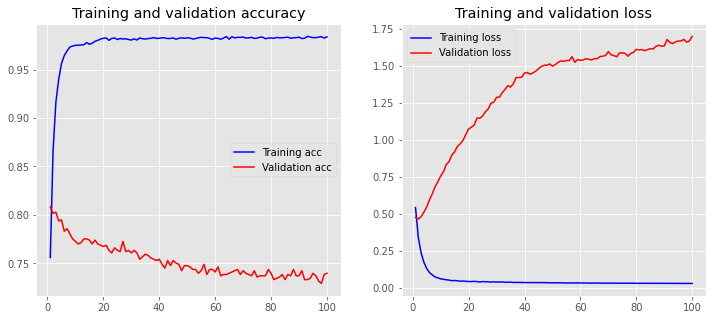

In [95]:
plot_history(first_history)

In [96]:
loss, accuracy = model.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7444


In [97]:
firstPredictions = list(map(lambda x: x[0], model.predict_classes(actual_tp_test_only_text)))

In [98]:
firstPredictionsDF = pd.DataFrame(data={'id': test_limpio["id"], 'target': firstPredictions})
firstPredictionsDF.head(10)

,id,target
0,8233,1
1,1541,0
2,8819,0
3,6080,1
4,6008,0
5,3624,0
6,5536,0
7,10509,1
8,1738,0
9,10438,0


In [99]:
firstPredictionsDF.to_csv('NN_predictions_first_model.csv', index=False)

## Segundo modelo, agrego ciudades y Tokenizer en vez de count para las words

In [100]:
non_null_locations = train_limpio[train_limpio.location.notnull()]["location"].to_numpy()
non_null_locations

array(['LAGOS', 'TX', 'CO', ..., 'TX', 'Australia', 'Pretoria'],
      dtype=object)

In [101]:
encoder = LabelEncoder()
locations = encoder.fit_transform(non_null_locations)
len(locations)

5080

In [102]:
encoder = OneHotEncoder(sparse=False)
locations = locations.reshape((5080, 1))
encoder.fit_transform(locations)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [103]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_limpio["text"].values.astype('U'))

X_train = tokenizer.texts_to_sequences(train["text"].values.astype('U'))
X_val = tokenizer.texts_to_sequences(val["text"].values.astype('U'))
X_test = tokenizer.texts_to_sequences(test["text"].values.astype('U'))

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train_limpio["text"].values[2])
print(X_train[2])

no uk train accid fatal for year run despit increas in passeng journey healthandsafeti
[2531, 2190, 173, 1080, 892, 249, 32, 181, 9, 2, 495, 50, 8, 3013]


In [104]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Pruebo solo texto, modelo mas complejo con maxPooling y mejor embedding

In [105]:
embedding_dim = 50

model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(layers.GlobalMaxPool1D())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model1.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 100, 50)           675500    
_________________________________________________________________
global_max_pooling1d_27 (Glo (None, 50)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 11        
Total params: 676,021
Trainable params: 676,021
Non-trainable params: 0
_________________________________________________________________


Testing Accuracy:  0.7536


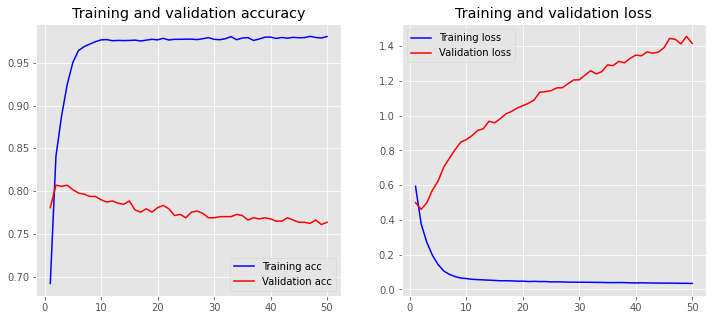

In [106]:
second_history = model1.fit(X_train, train["target"].to_numpy(),
                    epochs=50,
                    verbose=False,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

loss, accuracy = model1.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(second_history)

## Tercer modelo

In [107]:
embedding_dim = 100

model2 = Sequential()
model2.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(128, 5, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model2.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 100, 100)          1351000   
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_28 (Glo (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 11        
Total params: 1,416,429
Trainable params: 1,416,429
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9826
Testing Accuracy:  0.7720


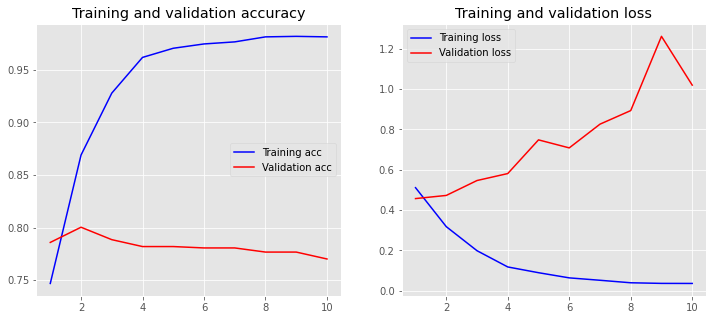

In [108]:
third_history = model2.fit(X_train, train["target"].to_numpy(),
                    epochs=10,
                    verbose=False,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)
loss, accuracy = model2.evaluate(X_train, train["target"].to_numpy(), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(third_history)


## Cuarto Modelo

In [109]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model3 = Sequential()
    model3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model3.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model3.add(layers.GlobalMaxPooling1D())
    model3.add(layers.Dense(10, activation='relu'))
    model3.add(layers.Dense(1, activation='sigmoid'))
    model3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model3

param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'output.txt'

source = "twitter"
# Run grid search for each source (yelp, amazon, imdb)
print('Running grid search for data set :', "twitter")
sentences = train_limpio["text"].values.astype('U')
# Train-test split
train = pd.concat([train_limpio_true.iloc[:3000], train_limpio_false.iloc[:4000]]).sample(frac=1).reset_index(drop=True)
test = pd.concat([train_limpio_true.iloc[3000:], train_limpio_false.iloc[4000:]]).sample(frac=1).reset_index(drop=True)

# Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences)
X_train = tokenizer.texts_to_sequences(train["text"].values.astype('U'))
X_test = tokenizer.texts_to_sequences(test["text"].values.astype('U'))

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
model3 = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model3, param_distributions=param_grid,
                              cv=10, verbose=1, n_iter=10)
grid_result = grid.fit(X_train, train["target"])

# Evaluate testing set
test_accuracy = grid.score(X_test, test["target"])

# Save and evaluate results
#     prompt = input(f'finished {source}; write to file and proceed? [y/n]')
#     if prompt.lower() not in {'y', 'true', 'yes'}:
#         break
#     with open(output_file, 'w+') as f:
s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(
        source,
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
print(output_string)
#         f.write(output_string)

Running grid search for data set : twitter


/home/lucasotero/datos/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits
